In [4]:
import datetime
import json
import os
import random
import sys
import warnings
import pandas as pd

sys.path.append(os.path.join(os.getcwd(), '../../../common'))
from ppg_feature_processor import generate_train_feature

# Suppress specific warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, message=".*Conversion of an array with ndim > 0 to a scalar is deprecated.*")

In [5]:
# 读取 Excel 文件'
middleSchool_userProfile_file_new = './outdir/MiddleSchool_Depression_Anxiety.xlsx'
middleSchool_userProfile_file = r'.././outdir/MiddleSchool_Depression_Anxiety.xlsx'
hospital_userProfile_file = '../../../../Data/unhealthy_clinic_results.xlsx'

In [6]:
### READ THE HOSPITAL SUBJECTS
df_hospital = pd.read_excel(hospital_userProfile_file)
print(df_hospital.columns)

hospital_positive_subjects_df = df_hospital[(df_hospital['抑郁'] == 1) & (df_hospital['年龄'] <= 15)][['床号', '性别', '年龄', '抑郁']]
print(hospital_positive_subjects_df)


hospital_positive_subjects = hospital_positive_subjects_df['床号'].tolist()
print("\nHospital Positive Depression subjects: ", hospital_positive_subjects)

Index(['床号', '性别', '年龄', '入院时间', '入院诊断', '病情备注', '抑郁', '焦虑', '双向情感障碍', '睡眠障碍'], dtype='object')
               床号 性别  年龄  抑郁
17  20240619_2A50  女  13   1
45  20240717_2A12  女  15   1
49  20240717_2A21  女  14   1

Hospital Positive Depression subjects:  ['20240619_2A50', '20240717_2A12', '20240717_2A21']


In [7]:
depression_positive_threshold = 10
depression_negative_threshold = 0

In [8]:
### READ THE MIDDLESCHOOL SUBJECTS
df_middle = pd.read_excel(middleSchool_userProfile_file_new, sheet_name= 'PHQ')
print(f"Midlle schold available subject count: {df_middle.shape}")


middle_pos_subjects = df_middle[df_middle['depression_sum']>=depression_positive_threshold]['subjectid'].values.tolist()
middle_neg_subjects = df_middle[df_middle['depression_sum']<=depression_negative_threshold]['subjectid'].values.tolist()

print(f"middle depression positive subjects count: {len(middle_pos_subjects)}")
print(f"middle depression negative subjects count: {len(middle_neg_subjects)}")

Midlle schold available subject count: (322, 36)
middle depression positive subjects count: 32
middle depression negative subjects count: 88


In [9]:
profile_dict = dict()

for _, row in df_hospital.iterrows():
    userId = row['床号']
    gender = 'Male' if row['性别'] == '男' else 'Female'
    age = row['年龄']
    profile_dict[userId] = (gender, age)
for _, row in df_middle.iterrows():
    userId = row['subjectid']
    gender = row['gender']
    age = row['age']
    profile_dict[userId] = (gender, age)



In [10]:
test_neg_subjects = ['695153b8-cd54-28f7-5e2d-b43ef7a12347',
       'e1a05473-85af-4aaf-dff5-9a9a507b188d',
       'bb2eaaba-1b05-bf28-3bd6-7c76fa5fd943',
       '40b9a027-fc21-b774-38b3-5d399ac1583c',
       'c831132a-79ed-6676-ad6c-811e7d40789c',
       'd2adc252-fd1e-659a-5b27-37327b37c4a4',
       'c5cf4093-8c88-3388-dd4a-8de8169eac4d',
       '3b28f19d-7fd1-5d93-8fae-b6eae8ca3b82']

In [11]:
test_pos_subjects = ['6b209cbb-d1b5-72ad-62f8-a698a20eeaa8',
       '0e88cac0-231c-e492-409c-8a5d2683b181',
       '6315febc-2fb1-e8e9-5e42-b60fe3d14f47',
       'dc7e8552-e3c4-4695-379c-10e144338a4b',
       '29a8784b-8752-4de0-579c-034c95044509',
       'f34fb6c0-c2f7-7367-3e25-d101c0605938',
       'bf102cd1-feed-4807-9ce7-d8bbfe9d0afd',
       'b61f44a3-7e22-8127-7d75-2060d82e1a9b',
       '43cb9b81-23c1-a136-bd28-41cae93082a3',
       '2a4bd1c8-888b-915b-d645-1ae939a492c5']

In [13]:
random.shuffle(middle_pos_subjects)
random.shuffle(middle_neg_subjects)

test_subject_count = 8

# test_pos_subjects = middle_pos_subjects[0:test_subject_count]
# test_neg_subjects = middle_neg_subjects[0:test_subject_count]

train_pos_subjects = hospital_positive_subjects+ [subject for subject in middle_pos_subjects if subject not in test_pos_subjects]
train_neg_subjects = [subject for subject in middle_neg_subjects if subject not in test_neg_subjects]

print(f"train postive subjects: {len(train_pos_subjects)}")
print(f"train negative subjects: {len(train_neg_subjects)}")

print(f"test postive subjects: {len(test_pos_subjects)}")
print(f"test negative subjects: {len(test_neg_subjects)}")


train postive subjects: 25
train negative subjects: 80
test postive subjects: 10
test negative subjects: 8


In [14]:
def load_wave_middleSchool(path):
    try:
        with open(path, 'r', encoding='utf-8') as file:  
            data = json.load(file)
        return data["ppg_raw_data"]
    except:
        print("Subject Not Loaded")
        pass

def load_wave_university_or_hospital(path):
    with open(path, 'r', encoding='utf-8') as file:  
            data = json.load(file)
            list_data = data['MesureData']['Datas']
            final = [i for i in list_data]
            return final

In [15]:
sample_freq = 125
sample_window_minute = 1.0

middle_file_dir = r'C:\Users\Administrator\Desktop\middle_school_data\ppg_data'
hospital_file_dir = r'C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\unhealthy'

In [16]:
def generate_dataset(subject_collection, label, data_aug_times=1):
    ignored_id = []
    dataset = pd.DataFrame()
    for subject in subject_collection:
            subject_wave = []

            if subject in (middle_pos_subjects + middle_neg_subjects):
                files = os.listdir(middle_file_dir)
                for file in files:
                    if file.startswith(subject) and file.endswith('.json'):
                        file_path = os.path.join(middle_file_dir, file)
                        print(f"middle file path: {file_path}")
                        tmp_wave = load_wave_middleSchool(file_path)
                        subject_wave += tmp_wave

            elif subject in hospital_positive_subjects:
                files = os.listdir(hospital_file_dir)
                for file in files:
                    if file.startswith(subject) and file.endswith('.json'):
                        file_path = os.path.join(hospital_file_dir, file)
                        print(f"hospital file path: {file_path}")
                        tmp_wave = load_wave_university_or_hospital(file_path)
                        subject_wave += tmp_wave
            # The middle school subjects.
            
            if len(subject_wave) < (sample_freq * (sample_window_minute) * 60):
                print(f"Small time for subj: {subject} is: {len(subject_wave)/(sample_freq*60)}")
                ignored_id.append({'id': id, 'Time Length of data in minute ': f"{len(subject_wave)/(125 * 60):.02f}"})
                continue
            else:
                print(f"Recording time for subj: {subject} is: {len(subject_wave)/(sample_freq*60)}")
                subject_dataset = generate_train_feature(subject, subject_wave, label, profile_dict[subject][0], profile_dict[subject][1], sample_freq, sample_window_minute, data_aug_times, if_gender = True)
                dataset = pd.concat([dataset, subject_dataset], ignore_index=True)
    return dataset




In [17]:
train_pos_dataset = generate_dataset(train_pos_subjects, label=1, data_aug_times=3)
train_neg_dataset = generate_dataset(train_neg_subjects, label=0, data_aug_times=1)

hospital file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\unhealthy\20240619_2A50_PPG_ 20240619_150828.json
Small time for subj: 20240619_2A50 is: 0.0021333333333333334
hospital file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\unhealthy\20240717_2A12_PPG_ 20240717_145530.json
Recording time for subj: 20240717_2A12 is: 50.06666666666667
hospital file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\unhealthy\20240717_2A21_PPG_ 20240717_153140.json
hospital file path: C:\Users\Administrator\Desktop\PPG_dataset\PPG_Dataset_ALL\unhealthy\20240717_2A21_PPG_ 20240717_160427.json
Recording time for subj: 20240717_2A21 is: 60.1
middle file path: C:\Users\Administrator\Desktop\middle_school_data\ppg_data\be2be15e-16cd-a936-975e-5724d35df0d9.json
Recording time for subj: be2be15e-16cd-a936-975e-5724d35df0d9 is: 15.066666666666666
middle file path: C:\Users\Administrator\Desktop\middle_school_data\ppg_data\5eae2457-6636-54b5-7789-0bfcf4f0d

In [18]:
test_pos_dataset = generate_dataset(test_pos_subjects, label=1, data_aug_times=1)
test_neg_dataset = generate_dataset(test_neg_subjects, label=0, data_aug_times=1)

middle file path: C:\Users\Administrator\Desktop\middle_school_data\ppg_data\6b209cbb-d1b5-72ad-62f8-a698a20eeaa8.json
Recording time for subj: 6b209cbb-d1b5-72ad-62f8-a698a20eeaa8 is: 14.983333333333333
middle file path: C:\Users\Administrator\Desktop\middle_school_data\ppg_data\0e88cac0-231c-e492-409c-8a5d2683b181.json
Recording time for subj: 0e88cac0-231c-e492-409c-8a5d2683b181 is: 14.366666666666667
middle file path: C:\Users\Administrator\Desktop\middle_school_data\ppg_data\6315febc-2fb1-e8e9-5e42-b60fe3d14f47.json
Recording time for subj: 6315febc-2fb1-e8e9-5e42-b60fe3d14f47 is: 15.033333333333333
middle file path: C:\Users\Administrator\Desktop\middle_school_data\ppg_data\dc7e8552-e3c4-4695-379c-10e144338a4b.json
Recording time for subj: dc7e8552-e3c4-4695-379c-10e144338a4b is: 15.1
middle file path: C:\Users\Administrator\Desktop\middle_school_data\ppg_data\29a8784b-8752-4de0-579c-034c95044509.json
Recording time for subj: 29a8784b-8752-4de0-579c-034c95044509 is: 15.0
middle f

In [19]:
print(f"train pos sample shape: {train_pos_dataset.shape}")
print(f"train neg sample shape: {train_neg_dataset.shape}")

print(f"test pos sample shape: {test_neg_dataset.shape}")
print(f"test neg sample shape: {test_pos_dataset.shape}")

train pos sample shape: (1185, 40)
train neg sample shape: (1094, 40)
test pos sample shape: (120, 40)
test neg sample shape: (147, 40)


In [20]:
columns_drop = []
for col in train_pos_dataset.columns[:-4]:
    nan_count = (train_pos_dataset[col] == 0).sum() 
    if nan_count > (len(train_pos_dataset) // 4): 
        columns_drop.append(col)

train_pos_dataset_final = train_pos_dataset.drop(columns=columns_drop, inplace=False)
train_neg_dataset_final = train_neg_dataset.drop(columns=columns_drop, inplace=False)

test_pos_dataset_final = test_pos_dataset.drop(columns=columns_drop, inplace=False)
test_neg_dataset_final = test_neg_dataset.drop(columns=columns_drop, inplace=False)

In [21]:
print(f"After remove the invalid columns, train pos shape: {train_pos_dataset_final.shape}")
print(f"After remove the invalid columns, train neg shape: {train_neg_dataset_final.shape}")

print(f"After remove the invalid columns, test pos shape: {test_pos_dataset_final.shape}")
print(f"After remove the invalid columns, test neg shape: {test_neg_dataset_final.shape}")

After remove the invalid columns, train pos shape: (1185, 32)
After remove the invalid columns, train neg shape: (1094, 32)
After remove the invalid columns, test pos shape: (147, 32)
After remove the invalid columns, test neg shape: (120, 32)


#### Do The Normalization for the Train Dataset and Test Dataset

In [22]:
profile_columns = ['wave_quality', 'age', 'gender', 'label', 'id']

In [23]:
# 合并训练集
train_combined = pd.concat([train_pos_dataset_final, train_neg_dataset_final])

# 需要归一化的列
columns_to_normalize = train_combined.columns.difference(profile_columns)

# 计算最大值和最小值
min_values = train_combined[columns_to_normalize].min()
max_values = train_combined[columns_to_normalize].max()

# 保存最大值和最小值到CSV
current_date = datetime.datetime.now().strftime("%Y-%m-%d")
outdir = os.path.join(os.getcwd(), 'outdir')
os.makedirs(outdir, exist_ok=True)
min_max_df = pd.DataFrame({'min': min_values, 'max': max_values})
min_max_df.to_csv(f'{outdir}/ppg_depression_norm_minmax_values_{current_date}.csv', index=True)


# 定义min-max归一化函数
def normalize(df, min_values, max_values):
    return (df - min_values) / (max_values - min_values)

# 对训练集进行归一化
train_pos_dataset_final[columns_to_normalize] = normalize(train_pos_dataset_final[columns_to_normalize], min_values, max_values)
train_neg_dataset_final[columns_to_normalize] = normalize(train_neg_dataset_final[columns_to_normalize], min_values, max_values)

# 从CSV文件中读取最小值和最大值
min_max_df = pd.read_csv(f'{outdir}/ppg_depression_norm_minmax_values_{current_date}.csv', index_col=0)
min_values = min_max_df['min']
max_values = min_max_df['max']

# 对测试集进行归一化
test_pos_dataset_final[columns_to_normalize] = normalize(test_pos_dataset_final[columns_to_normalize], min_values, max_values)
test_neg_dataset_final[columns_to_normalize] = normalize(test_neg_dataset_final[columns_to_normalize], min_values, max_values)


#### Save As Pkl File

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

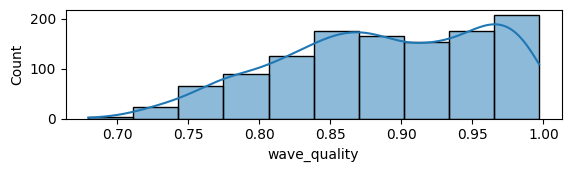

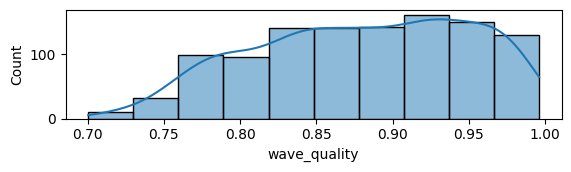

<Axes: xlabel='wave_quality', ylabel='Count'>

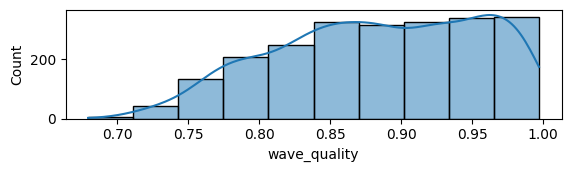

In [25]:
from matplotlib import figure

plt.subplot(3, 1, 1)  # 1行2列，第1个子图
sns.histplot(train_pos_dataset['wave_quality'], kde=True, bins=10)
plt.show()

plt.subplot(3, 1, 2)  # 1行2列，第1个子图
sns.histplot(train_neg_dataset['wave_quality'], kde=True, bins=10)
plt.show()

plt.subplot(3, 1, 3)  # 1行2列，第1个子图
sns.histplot(train_combined['wave_quality'], kde=True, bins=10)

In [26]:
wave_quality_threshold = 0.9

In [27]:
print(f"train pos sample shape: {train_pos_dataset.shape}")
print(f"train neg sample shape: {train_neg_dataset.shape}")

print(f"test pos sample shape: {test_neg_dataset.shape}")
print(f"test neg sample shape: {test_pos_dataset.shape}")

train pos sample shape: (1185, 40)
train neg sample shape: (1094, 40)
test pos sample shape: (120, 40)
test neg sample shape: (147, 40)


In [28]:
train_pos_dataset_final_filter = train_pos_dataset_final[train_pos_dataset_final['wave_quality'] >= wave_quality_threshold]
train_neg_dataset_final_filter = train_neg_dataset_final[train_neg_dataset_final['wave_quality'] >= wave_quality_threshold]

print(f"After quality filter, train positive sample count: {train_pos_dataset_final_filter.shape[0]}")
print(f"After quality filter, train negative sample count: {train_neg_dataset_final_filter.shape[0]}")


After quality filter, train positive sample count: 544
After quality filter, train negative sample count: 479


In [29]:
sample_folder = os.path.join(os.getcwd(), 'samples')
os.makedirs(sample_folder, exist_ok=True)

# 定义要保存的文件路径
train_pos_path = os.path.join(sample_folder, 'train_pos_dataset.pkl')
train_neg_path = os.path.join(sample_folder, 'train_neg_dataset.pkl')
test_pos_path = os.path.join(sample_folder, 'test_pos_dataset.pkl')
test_neg_path = os.path.join(sample_folder, 'test_neg_dataset.pkl')

# 保存 DataFrame 为 .pkl 文件
train_pos_dataset_final[train_pos_dataset_final['wave_quality'] >= wave_quality_threshold].to_pickle(train_pos_path)
train_neg_dataset_final[train_neg_dataset_final['wave_quality'] >= wave_quality_threshold].to_pickle(train_neg_path)
test_pos_dataset_final.to_pickle(test_pos_path)
test_neg_dataset_final.to_pickle(test_neg_path)

In [30]:
print(train_pos_dataset_final.columns)

Index(['HRV_MeanNN', 'HRV_SDNN', 'HRV_RMSSD', 'HRV_SDSD', 'HRV_CVNN',
       'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN', 'HRV_IQRNN',
       'HRV_SDRMSSD', 'HRV_Prc20NN', 'HRV_Prc80NN', 'HRV_pNN50', 'HRV_pNN20',
       'HRV_MinNN', 'HRV_MaxNN', 'HRV_HTI', 'HRV_TINN', 'HRV_LF', 'HRV_HF',
       'HRV_VHF', 'HRV_TP', 'HRV_LFHF', 'HRV_LFn', 'HRV_HFn', 'HRV_LnHF',
       'wave_quality', 'label', 'id', 'age', 'gender'],
      dtype='object')
